### 1. Installing dependencies

In [ ]:
!pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.9 MB/s eta 0:00:00


### 2. importing packages

In [ ]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback


from gym_anytrading.envs import StocksEnv
from finta import TA

### Constant

In [ ]:
WINDOW_SIZE = 25
AMOUNT_OF_EPISODES = 50
INITIAL_CAPITAL = 1000
DATASET_PATH = '/content/TESLA RL training data - 1 Sentiment 12.2024.csv'


### Methods

In [ ]:
def calculate_calmar_ratio(initial_capital,final_capital,peak_value,tough_value):

  cummulative_return = final_capital / initial_capital - 1

  annualized_return = (1 + cummulative_return) ** (365 / 252) - 1

  mdd = (peak_value - tough_value) / peak_value

  calmar_ratio = annualized_return / mdd
  return calmar_ratio

### 3. Read the dataset and preprocess it

In [ ]:
df = pd.read_csv(DATASET_PATH)

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)

df.sort_index(inplace=True)

df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

df['Day'] = df.index.dayofweek

### Calculate technical indicators using finta  

In [ ]:
df['SMA'] = TA.SMA(df, WINDOW_SIZE)
df['RSI'] = TA.RSI(df, WINDOW_SIZE)
df['MOM'] = TA.MOM(df, WINDOW_SIZE)
df['EMA'] = TA.EMA(df, WINDOW_SIZE)
df['AROONOSC'] = TA.AO(df,WINDOW_SIZE)
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Close,High,Low,Open,Volume,Sentiment,Predicted_Close,Day,SMA,RSI,MOM,EMA,AROONOSC
Date,,,,,,,,,,,,,,
2014-01-02,-1.599626,-1.599626,-1.609751,-1.606774,-1.604716,-0.191212,0,-1.531689,3,0.0,0.000000,0.0,-1.599626,0.0
2014-01-03,-1.608201,-1.608201,-1.614303,-1.573761,-1.601537,-0.530397,0,-1.566396,4,0.0,0.000000,0.0,-1.604085,0.0
2014-01-06,-1.648851,-1.648851,-1.642399,-1.627870,-1.601537,-0.379111,0,-1.551651,0,0.0,0.000000,0.0,-1.620216,0.0
2014-01-07,-1.611377,-1.611377,-1.642399,-1.627709,-1.639363,-0.453380,0,-1.581032,1,0.0,44.400253,0.0,-1.617734,0.0
2014-01-08,-1.580889,-1.580889,-1.590601,-1.571184,-1.619814,-0.196936,0,-1.576943,2,0.0,59.601318,0.0,-1.609141,0.0


### Trading Environment

In [ ]:
class MyCustomEnv(StocksEnv):

  def __init__(self, df, window_size, frame_bound, **kwargs):
    super().__init__(df, window_size, frame_bound, **kwargs)

  def reset(self, seed=None, options=None):
    self._truncated = False
    self._current_tick = self._start_tick
    self._last_trade_tick = self._current_tick - 1
    self._position = Positions.Short
    self._position_history = (self.window_size * [None]) + [self._position]
    self._total_reward = INITIAL_CAPITAL
    self._total_profit = INITIAL_CAPITAL  # unit
    self._first_rendering = True
    self.history = {}

    observation = self._get_observation()
    info = self._get_info()

    if self.render_mode == 'human':
        self._render_frame()

    return observation, info

  def _process_data (self):
    start = self.frame_bound[0] - self.window_size
    # print('env',env._position)
    end = self.frame_bound[1]
    prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = self.df.loc[:, ['Close','Sentiment','Predicted_Close','SMA', 'RSI', 'MOM', 'EMA', 'AROONOSC']].to_numpy()[start:end]
    # Reshape diff to (282, 1)
    diff_reshaped = diff.reshape(len(diff), 1)

    # Concatenate along the second axis (columns)
    signal_features = np.concatenate((signal_features, diff_reshaped), axis=1)


    return prices, signal_features





  def _calculate_reward(self, action):
      step_reward = 0

      trade = False
      if (
          (action == Actions.Buy.value and self._position == Positions.Short) or
          (action == Actions.Sell.value and self._position == Positions.Long)
      ):
          trade = True

      if trade:
          current_price = self.prices[self._current_tick]
          last_trade_price = self.prices[self._last_trade_tick]
          price_diff = current_price - last_trade_price

          # if self._position == Positions.Long:
          step_reward += price_diff

      return step_reward

  def _update_profit(self, action):
      trade = False
      if (
          (action == Actions.Buy.value and self._position == Positions.Short) or
          (action == Actions.Sell.value and self._position == Positions.Long)
      ):
          trade = True

      if trade or self._truncated:
          current_price = self.prices[self._current_tick]
          last_trade_price = self.prices[self._last_trade_tick]

          # if self._position == Positions.Long:
          shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
          self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price

  def step(self, action):
    self._truncated = False
    self._current_tick += 1

    if self._current_tick == self._end_tick:
        self._truncated = True

    step_reward = self._calculate_reward(action)
    self._total_reward += step_reward

    self._update_profit(action)

    trade = False
    if (
        (action == Actions.Buy.value and self._position == Positions.Short) or
        (action == Actions.Sell.value and self._position == Positions.Long)
    ):
        trade = True

    if trade:
        self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick

    self._position_history.append(self._position)
    observation = self._get_observation()
    info = self._get_info()
    self._update_history(info)

    if self.render_mode == 'human':
        self._render_frame()

    return observation, step_reward, False, self._truncated, info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dataset split

In [ ]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  1258
test_df:  252


In [ ]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

In [ ]:
env.signal_features[:1,:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-1.59962597,  0.        , -1.53168863,  0.        ,  0.        ,
         0.        , -1.59962597,  0.        ,  0.        ]])

In [ ]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [ ]:
env.action_space.sample()

1

Sell = 0

Buy = 1

In [ ]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (25, 9), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [ ]:
env.observation_space.sample()

array([[ 7.2651300e+09,  4.1587377e+09,  3.1689997e+09, -3.8910223e+09,
         7.7303639e+09,  7.8000901e+09,  6.1335050e+09, -2.6330388e+09,
         9.6779213e+08],
       [-8.0466657e+09, -5.4548367e+09,  3.5218939e+09,  2.6143793e+09,
        -4.3352837e+09,  7.7868411e+09, -6.3839386e+09,  3.6296169e+09,
         4.8401101e+08],
       [ 2.2843182e+09, -1.2049537e+09,  8.2466084e+09, -2.9334339e+09,
         4.3754936e+09,  2.7105444e+09,  2.1831683e+09, -7.6749594e+09,
         2.9946752e+09],
       [ 4.8944451e+09,  5.6683884e+09,  1.2655267e+09,  3.5288558e+09,
         5.4923735e+09,  5.2269164e+09, -3.7555213e+09,  9.2242166e+09,
        -1.2138054e+09],
       [-1.2230099e+09, -6.1306440e+09,  5.5526508e+09,  8.3544212e+09,
        -9.2019937e+09,  8.0244250e+09,  1.1349133e+09, -5.8839050e+09,
         4.6682854e+09],
       [-4.4244946e+09, -7.0649416e+09,  5.7189745e+09, -4.6084173e+09,
         3.8753165e+09, -1.5506138e+09,  2.2913748e+09, -6.0482217e+09,
        -5.

### 4. Create the environment and do some random action on it

info: {'total_reward': 1001.8580009868451, 'total_profit': -0.10250253588301238, 'position': <Positions.Long: 1>}


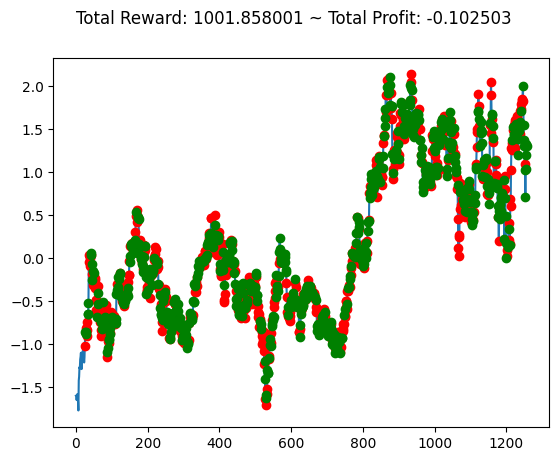

In [ ]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

### 5 creating and training the model

In [ ]:
model = A2C("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=62900)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 163      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.358   |
|    explained_variance | 0.00778  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.000137 |
|    value_loss         | 1.57e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.513   |
|    explained_variance | 3.22e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.102    |
|    value_loss         | 0.0396   |
-

### Evaluate model

info: {'total_reward': 1002.2184538942731, 'total_profit': 1726.926979164676, 'position': <Positions.Long: 1>}
peak_value 1002.4097957459542
tough_value 998.5159492219925


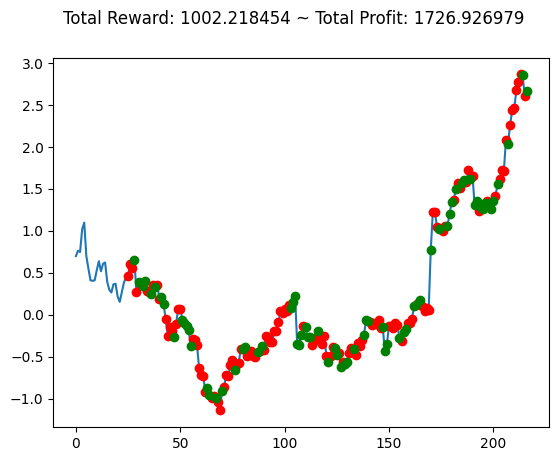

info: {'total_reward': 1002.2184538942724, 'total_profit': 1485.445518330363, 'position': <Positions.Long: 1>}
peak_value 1002.2184538942724
tough_value 998.5159492219922


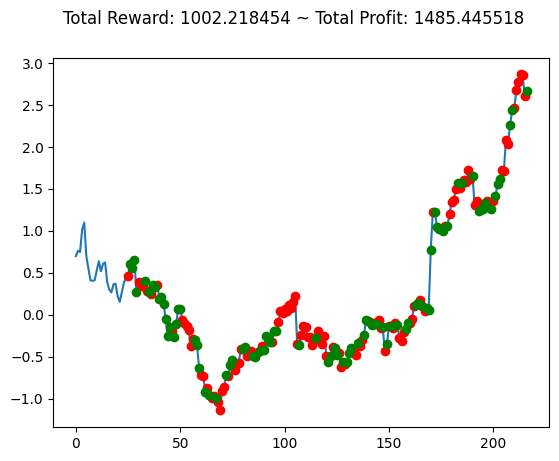

info: {'total_reward': 1002.2184538942726, 'total_profit': 1625.9495859040792, 'position': <Positions.Long: 1>}
peak_value 1002.4186882460481
tough_value 998.5159492219924


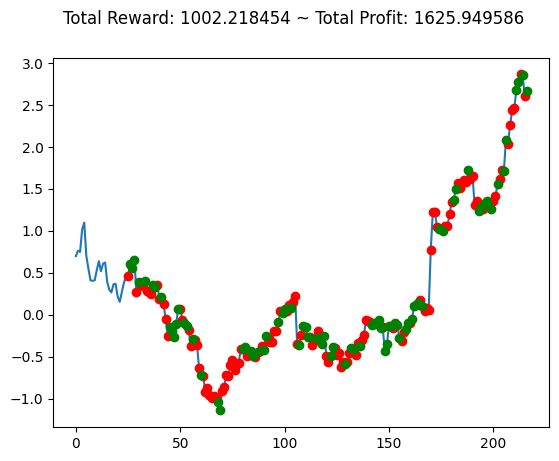

info: {'total_reward': 1002.2184538942728, 'total_profit': 1441.3626981192483, 'position': <Positions.Long: 1>}
peak_value 1002.4186882460483
tough_value 998.417658111504


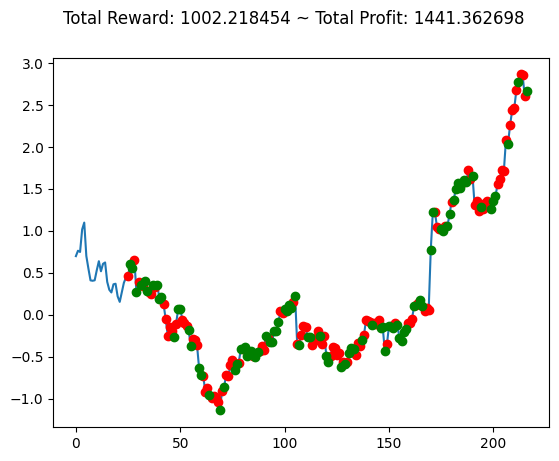

info: {'total_reward': 1002.1608134664349, 'total_profit': 1779.7435336929527, 'position': <Positions.Short: 0>}
peak_value 1002.4186882460479
tough_value 998.4176581115039


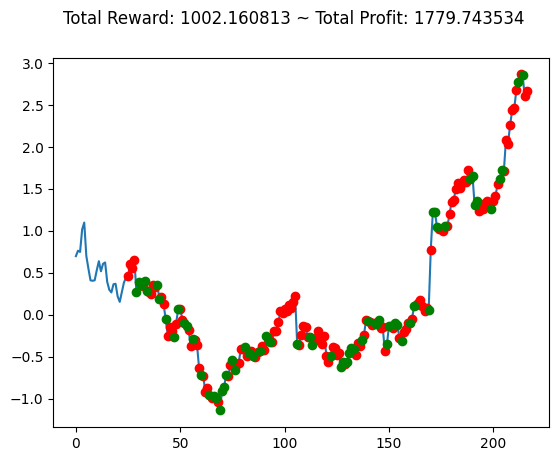

In [ ]:
calmar_ratio_list = []
total_reward_list = []
total_profit_list = []

for i in range(5):

  env = MyCustomEnv(df=test_df, frame_bound=(60, len(test_df)), window_size=WINDOW_SIZE)

  observation, info = env.reset()
  while True:
      action = model.predict(observation)
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      if done:
          print("info:", info)
          peak_value = np.max(env.history['total_reward'])
          tough_value = np.min(env.history['total_reward'])
          final_capital = info['total_reward']
          print('peak_value',peak_value)
          print('tough_value',tough_value)
          calmar_ratio = calculate_calmar_ratio(INITIAL_CAPITAL,final_capital,peak_value,tough_value)
          calmar_ratio_list.append(calmar_ratio)
          total_reward_list.append(info['total_reward'])
          total_profit_list.append(info['total_profit'])
          break

  plt.cla()
  env.unwrapped.render_all()
  plt.show()

In [ ]:
calmar_ratio_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.4641778810941782,
 0.6435284885372586,
 0.3033751460383179,
 0.26481059223968223,
 0.28693024587232135]

In [ ]:
print('Average Calmar Ratio: ', np.mean(calmar_ratio_list))
print('Average Total Reward: ', np.mean(total_reward_list))
print('Average Total Profit: ', np.mean(total_profit_list))



Average Calmar Ratio:  0.8227009009616106
Average Total Reward:  1002.2069258087053
Average Total Profit:  1611.8856630422638


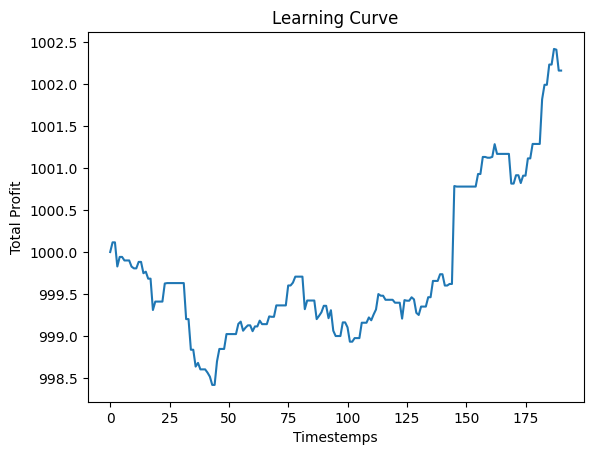

In [ ]:
plt.plot(env.history['total_reward'])
plt.xlabel('Timestemps')
plt.ylabel('Total Profit')
plt.title('Learning Curve')
plt.show()